In [1]:
import tiledb
import numpy as np
import time
import io
import boto3
from PIL import Image
from io import BytesIO

train_images = "s3://tiledb-gskoumas/airbus_ship_detection_tiledb/train_ship_images"
train_segs = "s3://tiledb-gskoumas/airbus_ship_detection_tiledb/train_ship_segments"

#val_images = "s3://tiledb-gskoumas/airbus_ship_detection_tiledb/val_ship_images"
#val_segs = "s3://tiledb-gskoumas/airbus_ship_detection_tiledb/val_ship_segments"

# Alteratively, you can create and pass a configuration object
# config = tiledb.Config({"sm.consolidation.mode": "fragment_meta"})
# ctx = tiledb.Ctx(config)

# print('Consolidating segments...')
# tiledb.consolidate(train_segs, ctx=ctx)
# print('Consolidating segments done!')


# print('Consolidating images...')
# tiledb.consolidate(train_images, ctx=ctx)
# print('Consolidating images done!')


print('Opening TileDB arrays...')
ctx = tiledb.Ctx()
start = time.time()
train_images_array = tiledb.open(train_images, 'r', ctx=ctx)
print('Time to open images array is ' + str(time.time() - start))

start = time.time()
train_segs_array = tiledb.open(train_segs, 'r', ctx=ctx)
print('Time to open segs array is ' + str(time.time() - start))

print('TileDB arrays opened!')

#val_images_array = tiledb.open(val_images, 'w', ctx=ctx)
#val_segs_array = tiledb.open(val_segs, 'w', ctx=ctx)

Opening TileDB arrays...
Time to open images array is 16.96421480178833
Time to open segs array is 0.14572691917419434
TileDB arrays opened!


In [2]:
def generator_tiledb(tiledb_images_obj, tiledb_labels_obj, shape, batch_size=32):
    """
    Yields the next training batch.
    """

    while True:  # Loop forever so the generator never terminates

        # Get index to start each batch
        for offset in range(0, shape, batch_size):

            # Get the samples you'll use in this batch. We have to convert structured numpy arrays to
            # numpy arrays.

            # Avoid reshaping error in last batch
            if offset + batch_size > shape:
                batch_size = shape - offset

            start = time.time()    
            x_train = tiledb_images_obj[offset:offset + batch_size]['rgb'].view(np.uint8).reshape(batch_size, 768, 768, 3)
            image_time = time.time() - start    
            
            # start = time.time()    
            # y_train = tiledb_labels_obj[offset:offset + batch_size]
            # segs_time = time.time() - start    

            
            # The generator-y part: yield the next training batch
            yield x_train, image_time

In [3]:
import multiprocessing

def initialize():
    global s3
    s3 = boto3.resource('s3')

def fectch_input(path):
    bucket = s3.Bucket('tiledb-gskoumas')
    object = bucket.Object(path)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)       


def s3_image_generator(files, batch_size = 32):
    
    # make a process pool to do the work
    pool = multiprocessing.Pool(multiprocessing.cpu_count(), initialize)
            
    for i in range(0, len(files), batch_size):
        file_names = files[i:i + batch_size]
        file_names = ['airbus_ship_detection/train_v2/' + file for file in file_names]
        batch_paths = np.array(file_names)
        
        start = time.time()
           
        batch_input =  pool.map(fectch_input, batch_paths)
        
        batch_x = np.array( batch_input )
        
        end = time.time() - start
        
        yield batch_x, end
        
    pool.close()
    pool.join()

In [4]:
import pandas as pd

shape = 150000

df = pd.read_csv('train_ship_segmentations_v2.csv', usecols=['ImageId', 'EncodedPixels'])

image_times_tiledb = []
image_times_simple = []

gen_tiledb = generator_tiledb(train_images_array, train_segs_array, shape=shape, batch_size=32)
gen_simple = s3_image_generator(df['ImageId'].tolist())

for i in range(100):
    print('Batch ' + str(i))
    batch_img_1, time_img = next(gen_tiledb)
    image_times_tiledb.append(time_img)
    
    batch_img_2, time_img = next(gen_simple)
    image_times_simple.append(time_img)
   
    assert(batch_img_1.shape == batch_img_2.shape)
    
    


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99


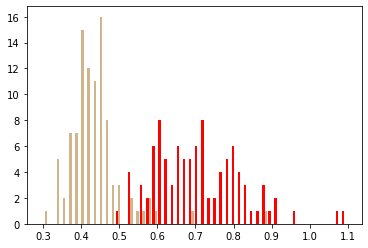

In [7]:
from matplotlib import pyplot as plt

colors = ['red', 'tan']

data = np.array([image_times_tiledb[1:], image_times_simple[1:]])

plt.hist(data.T, bins=50, histtype='bar', color=colors, label=['tiledb', 'raw jpeg'])

plt.show()
